# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'MChX-bandgap'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset)
    del train_dataset

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)
    del val_dataset, test_dataset

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Number of training   graphs: 88
Number of validation graphs: 11
Number of testing    graphs: 11


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

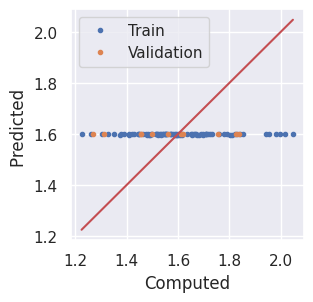

Epoch: 1, Train MAE: 0.1680, Val MAE: 0.1851
Epoch: 2, Train MAE: 0.1679, Val MAE: 0.1850
Epoch: 3, Train MAE: 0.1676, Val MAE: 0.1849
Epoch: 4, Train MAE: 0.1675, Val MAE: 0.1847
Epoch: 5, Train MAE: 0.1672, Val MAE: 0.1846
Epoch: 6, Train MAE: 0.1671, Val MAE: 0.1844
Epoch: 7, Train MAE: 0.1668, Val MAE: 0.1842
Epoch: 8, Train MAE: 0.1672, Val MAE: 0.1841
Epoch: 9, Train MAE: 0.1667, Val MAE: 0.1839
Epoch: 10, Train MAE: 0.1664, Val MAE: 0.1837


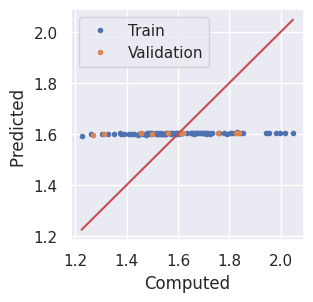

Epoch: 11, Train MAE: 0.1661, Val MAE: 0.1835
Epoch: 12, Train MAE: 0.1662, Val MAE: 0.1833
Epoch: 13, Train MAE: 0.1659, Val MAE: 0.1830
Epoch: 14, Train MAE: 0.1657, Val MAE: 0.1827
Epoch: 15, Train MAE: 0.1656, Val MAE: 0.1824
Epoch: 16, Train MAE: 0.1649, Val MAE: 0.1821
Epoch: 17, Train MAE: 0.1646, Val MAE: 0.1817
Epoch: 18, Train MAE: 0.1643, Val MAE: 0.1813
Epoch: 19, Train MAE: 0.1640, Val MAE: 0.1809
Epoch: 20, Train MAE: 0.1636, Val MAE: 0.1804


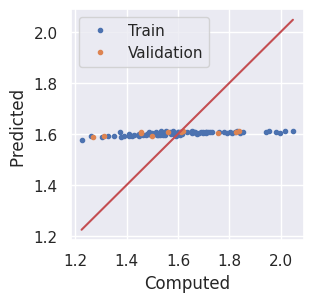

Epoch: 21, Train MAE: 0.1629, Val MAE: 0.1799
Epoch: 22, Train MAE: 0.1629, Val MAE: 0.1794
Epoch: 23, Train MAE: 0.1619, Val MAE: 0.1789
Epoch: 24, Train MAE: 0.1618, Val MAE: 0.1783
Epoch: 25, Train MAE: 0.1609, Val MAE: 0.1777
Epoch: 26, Train MAE: 0.1608, Val MAE: 0.1769
Epoch: 27, Train MAE: 0.1595, Val MAE: 0.1762
Epoch: 28, Train MAE: 0.1591, Val MAE: 0.1754
Epoch: 29, Train MAE: 0.1585, Val MAE: 0.1745
Epoch: 30, Train MAE: 0.1584, Val MAE: 0.1735


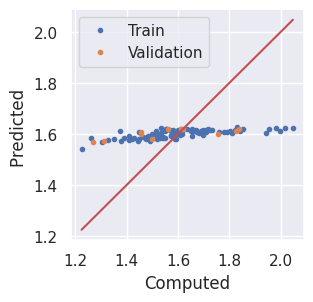

Epoch: 31, Train MAE: 0.1564, Val MAE: 0.1725
Epoch: 32, Train MAE: 0.1560, Val MAE: 0.1714
Epoch: 33, Train MAE: 0.1556, Val MAE: 0.1702
Epoch: 34, Train MAE: 0.1542, Val MAE: 0.1689
Epoch: 35, Train MAE: 0.1539, Val MAE: 0.1677
Epoch: 36, Train MAE: 0.1506, Val MAE: 0.1663
Epoch: 37, Train MAE: 0.1490, Val MAE: 0.1648
Epoch: 38, Train MAE: 0.1496, Val MAE: 0.1633
Epoch: 39, Train MAE: 0.1462, Val MAE: 0.1617
Epoch: 40, Train MAE: 0.1464, Val MAE: 0.1600


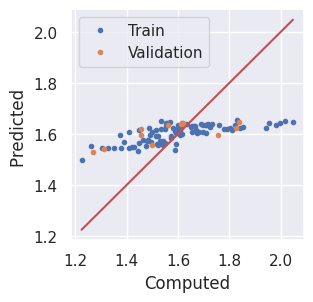

Epoch: 41, Train MAE: 0.1448, Val MAE: 0.1583
Epoch: 42, Train MAE: 0.1435, Val MAE: 0.1565
Epoch: 43, Train MAE: 0.1395, Val MAE: 0.1547
Epoch: 44, Train MAE: 0.1409, Val MAE: 0.1528
Epoch: 45, Train MAE: 0.1397, Val MAE: 0.1509
Epoch: 46, Train MAE: 0.1372, Val MAE: 0.1489
Epoch: 47, Train MAE: 0.1333, Val MAE: 0.1468
Epoch: 48, Train MAE: 0.1332, Val MAE: 0.1446
Epoch: 49, Train MAE: 0.1280, Val MAE: 0.1425
Epoch: 50, Train MAE: 0.1279, Val MAE: 0.1404


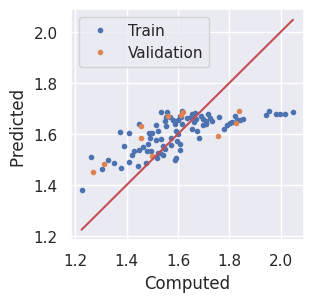

Epoch: 51, Train MAE: 0.1275, Val MAE: 0.1382
Epoch: 52, Train MAE: 0.1242, Val MAE: 0.1362
Epoch: 53, Train MAE: 0.1226, Val MAE: 0.1343
Epoch: 54, Train MAE: 0.1189, Val MAE: 0.1326
Epoch: 55, Train MAE: 0.1226, Val MAE: 0.1311
Epoch: 56, Train MAE: 0.1204, Val MAE: 0.1298
Epoch: 57, Train MAE: 0.1136, Val MAE: 0.1286
Epoch: 58, Train MAE: 0.1152, Val MAE: 0.1275
Epoch: 59, Train MAE: 0.1152, Val MAE: 0.1267
Epoch: 60, Train MAE: 0.1121, Val MAE: 0.1262


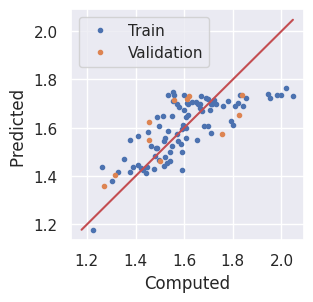

Epoch: 61, Train MAE: 0.1110, Val MAE: 0.1259
Epoch: 62, Train MAE: 0.1130, Val MAE: 0.1255
Epoch: 63, Train MAE: 0.1097, Val MAE: 0.1254
Epoch: 64, Train MAE: 0.1051, Val MAE: 0.1252
Epoch: 65, Train MAE: 0.1134, Val MAE: 0.1252
Epoch: 66, Train MAE: 0.1111, Val MAE: 0.1253
Epoch: 67, Train MAE: 0.1122, Val MAE: 0.1253
Epoch: 68, Train MAE: 0.1147, Val MAE: 0.1250
Epoch: 69, Train MAE: 0.1083, Val MAE: 0.1246
Epoch: 70, Train MAE: 0.1053, Val MAE: 0.1243


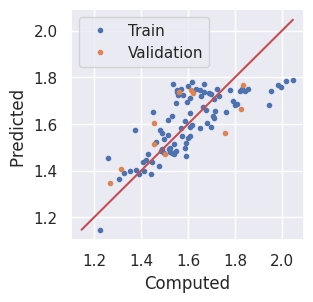

Epoch: 71, Train MAE: 0.1092, Val MAE: 0.1240
Epoch: 72, Train MAE: 0.1034, Val MAE: 0.1237
Epoch: 73, Train MAE: 0.0982, Val MAE: 0.1232
Epoch: 74, Train MAE: 0.1030, Val MAE: 0.1228
Epoch: 75, Train MAE: 0.1009, Val MAE: 0.1225
Epoch: 76, Train MAE: 0.1037, Val MAE: 0.1219
Epoch: 77, Train MAE: 0.1008, Val MAE: 0.1214
Epoch: 78, Train MAE: 0.1076, Val MAE: 0.1213
Epoch: 79, Train MAE: 0.1026, Val MAE: 0.1200
Epoch: 80, Train MAE: 0.1019, Val MAE: 0.1191


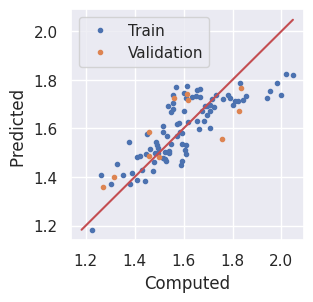

Epoch: 81, Train MAE: 0.0983, Val MAE: 0.1191
Epoch: 82, Train MAE: 0.1064, Val MAE: 0.1184
Epoch: 83, Train MAE: 0.0982, Val MAE: 0.1177
Epoch: 84, Train MAE: 0.0994, Val MAE: 0.1176
Epoch: 85, Train MAE: 0.1015, Val MAE: 0.1182
Epoch: 86, Train MAE: 0.0998, Val MAE: 0.1185
Epoch: 87, Train MAE: 0.1045, Val MAE: 0.1173
Epoch: 88, Train MAE: 0.1027, Val MAE: 0.1156
Epoch: 89, Train MAE: 0.0952, Val MAE: 0.1151
Epoch: 90, Train MAE: 0.0968, Val MAE: 0.1158


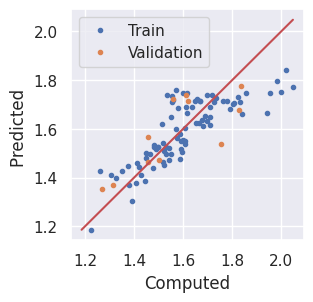

Epoch: 91, Train MAE: 0.0985, Val MAE: 0.1157
Epoch: 92, Train MAE: 0.1006, Val MAE: 0.1145
Epoch: 93, Train MAE: 0.0980, Val MAE: 0.1136
Epoch: 94, Train MAE: 0.0972, Val MAE: 0.1140
Epoch: 95, Train MAE: 0.0956, Val MAE: 0.1153
Epoch: 96, Train MAE: 0.0955, Val MAE: 0.1152
Epoch: 97, Train MAE: 0.0966, Val MAE: 0.1140
Epoch: 98, Train MAE: 0.0933, Val MAE: 0.1123
Epoch: 99, Train MAE: 0.0992, Val MAE: 0.1118
Epoch: 100, Train MAE: 0.0965, Val MAE: 0.1119


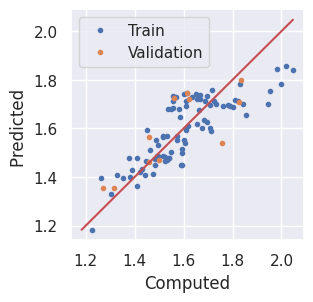

Epoch: 101, Train MAE: 0.0953, Val MAE: 0.1118
Epoch: 102, Train MAE: 0.0913, Val MAE: 0.1113
Epoch: 103, Train MAE: 0.0962, Val MAE: 0.1107
Epoch: 104, Train MAE: 0.0862, Val MAE: 0.1106
Epoch: 105, Train MAE: 0.0921, Val MAE: 0.1110
Epoch: 106, Train MAE: 0.0895, Val MAE: 0.1113
Epoch: 107, Train MAE: 0.0940, Val MAE: 0.1112
Epoch: 108, Train MAE: 0.0941, Val MAE: 0.1107
Epoch: 109, Train MAE: 0.0930, Val MAE: 0.1098
Epoch: 110, Train MAE: 0.0949, Val MAE: 0.1092


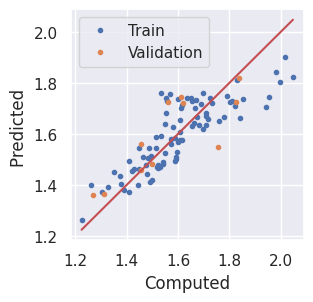

Epoch: 111, Train MAE: 0.0912, Val MAE: 0.1091
Epoch: 112, Train MAE: 0.0997, Val MAE: 0.1088
Epoch: 113, Train MAE: 0.0968, Val MAE: 0.1084
Epoch: 114, Train MAE: 0.0915, Val MAE: 0.1084
Epoch: 115, Train MAE: 0.0885, Val MAE: 0.1092
Epoch: 116, Train MAE: 0.0881, Val MAE: 0.1099
Epoch: 117, Train MAE: 0.0872, Val MAE: 0.1097
Epoch: 118, Train MAE: 0.0903, Val MAE: 0.1081
Epoch: 119, Train MAE: 0.0915, Val MAE: 0.1068
Epoch: 120, Train MAE: 0.0870, Val MAE: 0.1065


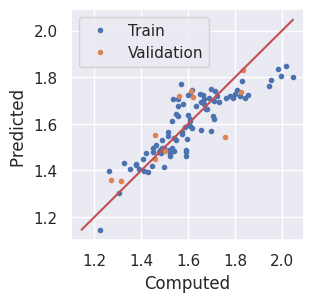

Epoch: 121, Train MAE: 0.0856, Val MAE: 0.1066
Epoch: 122, Train MAE: 0.0855, Val MAE: 0.1066
Epoch: 123, Train MAE: 0.0879, Val MAE: 0.1065
Epoch: 124, Train MAE: 0.0869, Val MAE: 0.1069
Epoch: 125, Train MAE: 0.0864, Val MAE: 0.1077
Epoch: 126, Train MAE: 0.0846, Val MAE: 0.1085
Epoch: 127, Train MAE: 0.0841, Val MAE: 0.1086
Epoch: 128, Train MAE: 0.0867, Val MAE: 0.1079
Epoch: 129, Train MAE: 0.0828, Val MAE: 0.1072
Epoch: 130, Train MAE: 0.0849, Val MAE: 0.1067


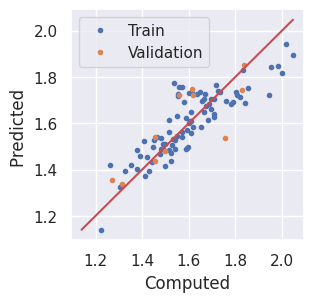

Epoch: 131, Train MAE: 0.0873, Val MAE: 0.1067
Epoch: 132, Train MAE: 0.0846, Val MAE: 0.1067
Epoch: 133, Train MAE: 0.0839, Val MAE: 0.1063
Epoch: 134, Train MAE: 0.0822, Val MAE: 0.1064
Epoch: 135, Train MAE: 0.0864, Val MAE: 0.1073
Epoch: 136, Train MAE: 0.0837, Val MAE: 0.1080
Epoch: 137, Train MAE: 0.0784, Val MAE: 0.1078
Epoch: 138, Train MAE: 0.0815, Val MAE: 0.1063
Epoch: 139, Train MAE: 0.0832, Val MAE: 0.1047
Epoch: 140, Train MAE: 0.0872, Val MAE: 0.1038


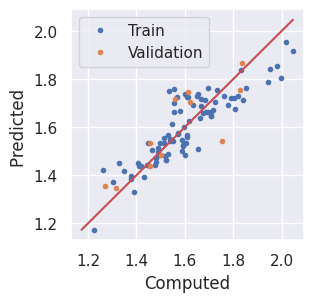

Epoch: 141, Train MAE: 0.0807, Val MAE: 0.1033
Epoch: 142, Train MAE: 0.0816, Val MAE: 0.1028
Epoch: 143, Train MAE: 0.0835, Val MAE: 0.1027
Epoch: 144, Train MAE: 0.0784, Val MAE: 0.1034
Epoch: 145, Train MAE: 0.0799, Val MAE: 0.1046
Epoch: 146, Train MAE: 0.0791, Val MAE: 0.1050
Epoch: 147, Train MAE: 0.0786, Val MAE: 0.1044
Epoch: 148, Train MAE: 0.0748, Val MAE: 0.1036
Epoch: 149, Train MAE: 0.0771, Val MAE: 0.1024
Epoch: 150, Train MAE: 0.0759, Val MAE: 0.1018


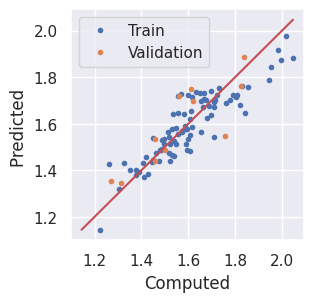

Epoch: 151, Train MAE: 0.0750, Val MAE: 0.1019
Epoch: 152, Train MAE: 0.0798, Val MAE: 0.1022
Epoch: 153, Train MAE: 0.0807, Val MAE: 0.1032
Epoch: 154, Train MAE: 0.0766, Val MAE: 0.1048
Epoch: 155, Train MAE: 0.0785, Val MAE: 0.1059
Epoch: 156, Train MAE: 0.0824, Val MAE: 0.1063
Epoch: 157, Train MAE: 0.0752, Val MAE: 0.1061
Epoch: 158, Train MAE: 0.0771, Val MAE: 0.1043
Epoch: 159, Train MAE: 0.0748, Val MAE: 0.1028
Epoch: 160, Train MAE: 0.0737, Val MAE: 0.1022


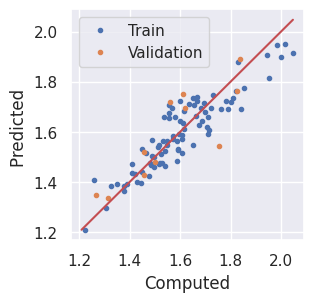

Epoch: 161, Train MAE: 0.0678, Val MAE: 0.1020
Epoch: 162, Train MAE: 0.0738, Val MAE: 0.1020
Epoch: 163, Train MAE: 0.0715, Val MAE: 0.1024
Epoch: 164, Train MAE: 0.0766, Val MAE: 0.1036
Epoch: 165, Train MAE: 0.0793, Val MAE: 0.1050
Epoch: 166, Train MAE: 0.0784, Val MAE: 0.1049
Epoch: 167, Train MAE: 0.0730, Val MAE: 0.1036
Epoch: 168, Train MAE: 0.0796, Val MAE: 0.1015
Epoch: 169, Train MAE: 0.0752, Val MAE: 0.0997
Epoch: 170, Train MAE: 0.0739, Val MAE: 0.0984


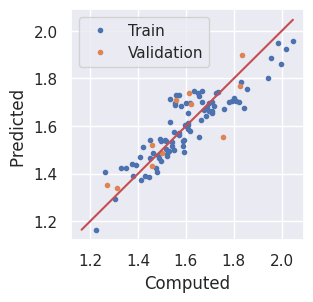

Epoch: 171, Train MAE: 0.0748, Val MAE: 0.0976
Epoch: 172, Train MAE: 0.0737, Val MAE: 0.0969
Epoch: 173, Train MAE: 0.0726, Val MAE: 0.0967
Epoch: 174, Train MAE: 0.0741, Val MAE: 0.0967
Epoch: 175, Train MAE: 0.0705, Val MAE: 0.0972
Epoch: 176, Train MAE: 0.0730, Val MAE: 0.0976
Epoch: 177, Train MAE: 0.0673, Val MAE: 0.0980
Epoch: 178, Train MAE: 0.0814, Val MAE: 0.0973
Epoch: 179, Train MAE: 0.0706, Val MAE: 0.0964
Epoch: 180, Train MAE: 0.0708, Val MAE: 0.0961


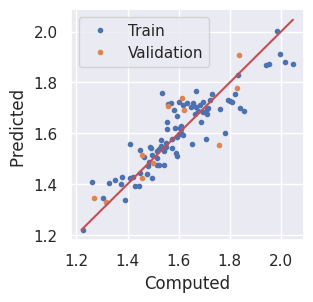

Epoch: 181, Train MAE: 0.0752, Val MAE: 0.0963
Epoch: 182, Train MAE: 0.0704, Val MAE: 0.0969
Epoch: 183, Train MAE: 0.0738, Val MAE: 0.0977
Epoch: 184, Train MAE: 0.0790, Val MAE: 0.0993
Epoch: 185, Train MAE: 0.0699, Val MAE: 0.1014
Epoch: 186, Train MAE: 0.0724, Val MAE: 0.1030
Epoch: 187, Train MAE: 0.0713, Val MAE: 0.1030
Epoch: 188, Train MAE: 0.0710, Val MAE: 0.1013
Epoch: 189, Train MAE: 0.0745, Val MAE: 0.1002
Epoch: 190, Train MAE: 0.0714, Val MAE: 0.0994


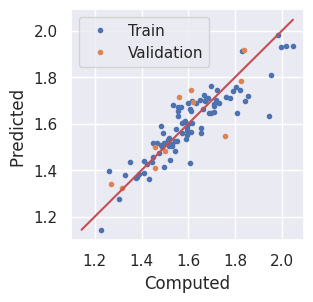

Epoch: 191, Train MAE: 0.0742, Val MAE: 0.0993
Epoch: 192, Train MAE: 0.0704, Val MAE: 0.0993
Epoch: 193, Train MAE: 0.0731, Val MAE: 0.0996
Epoch: 194, Train MAE: 0.0660, Val MAE: 0.1001
Epoch: 195, Train MAE: 0.0689, Val MAE: 0.1002
Epoch: 196, Train MAE: 0.0666, Val MAE: 0.1001
Epoch: 197, Train MAE: 0.0704, Val MAE: 0.0992
Epoch: 198, Train MAE: 0.0710, Val MAE: 0.0985
Epoch: 199, Train MAE: 0.0699, Val MAE: 0.0981
Epoch: 200, Train MAE: 0.0662, Val MAE: 0.0979


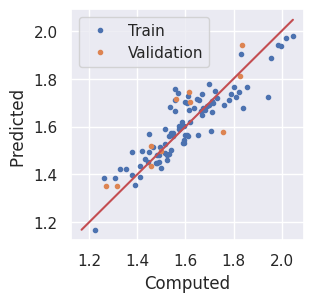

Epoch: 201, Train MAE: 0.0729, Val MAE: 0.0974
Epoch: 202, Train MAE: 0.0703, Val MAE: 0.0956
Epoch: 203, Train MAE: 0.0702, Val MAE: 0.0946
Epoch: 204, Train MAE: 0.0684, Val MAE: 0.0942
Epoch: 205, Train MAE: 0.0673, Val MAE: 0.0938
Epoch: 206, Train MAE: 0.0644, Val MAE: 0.0942
Epoch: 207, Train MAE: 0.0673, Val MAE: 0.0943
Epoch: 208, Train MAE: 0.0664, Val MAE: 0.0939
Epoch: 209, Train MAE: 0.0602, Val MAE: 0.0934
Epoch: 210, Train MAE: 0.0675, Val MAE: 0.0929


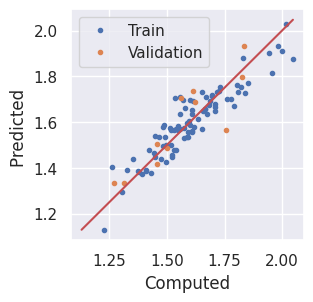

Epoch: 211, Train MAE: 0.0655, Val MAE: 0.0927
Epoch: 212, Train MAE: 0.0691, Val MAE: 0.0929
Epoch: 213, Train MAE: 0.0679, Val MAE: 0.0929
Epoch: 214, Train MAE: 0.0625, Val MAE: 0.0929
Epoch: 215, Train MAE: 0.0621, Val MAE: 0.0933
Epoch: 216, Train MAE: 0.0638, Val MAE: 0.0941
Epoch: 217, Train MAE: 0.0655, Val MAE: 0.0945
Epoch: 218, Train MAE: 0.0713, Val MAE: 0.0941
Epoch: 219, Train MAE: 0.0635, Val MAE: 0.0932
Epoch: 220, Train MAE: 0.0624, Val MAE: 0.0923


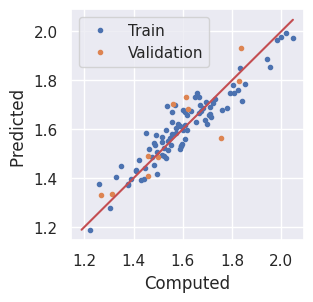

Epoch: 221, Train MAE: 0.0584, Val MAE: 0.0917
Epoch: 222, Train MAE: 0.0663, Val MAE: 0.0914
Epoch: 223, Train MAE: 0.0673, Val MAE: 0.0919
Epoch: 224, Train MAE: 0.0673, Val MAE: 0.0927
Epoch: 225, Train MAE: 0.0704, Val MAE: 0.0933
Epoch: 226, Train MAE: 0.0673, Val MAE: 0.0912
Epoch: 227, Train MAE: 0.0672, Val MAE: 0.0894
Epoch: 228, Train MAE: 0.0635, Val MAE: 0.0886
Epoch: 229, Train MAE: 0.0616, Val MAE: 0.0882
Epoch: 230, Train MAE: 0.0750, Val MAE: 0.0883


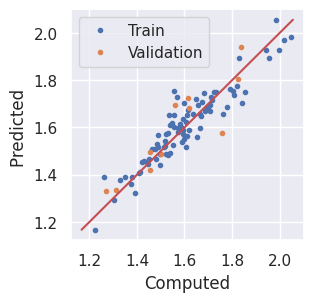

Epoch: 231, Train MAE: 0.0591, Val MAE: 0.0884
Epoch: 232, Train MAE: 0.0675, Val MAE: 0.0886
Epoch: 233, Train MAE: 0.0633, Val MAE: 0.0894
Epoch: 234, Train MAE: 0.0600, Val MAE: 0.0915
Epoch: 235, Train MAE: 0.0676, Val MAE: 0.0922
Epoch: 236, Train MAE: 0.0625, Val MAE: 0.0913
Epoch: 237, Train MAE: 0.0627, Val MAE: 0.0900
Epoch: 238, Train MAE: 0.0654, Val MAE: 0.0887
Epoch: 239, Train MAE: 0.0661, Val MAE: 0.0880
Epoch: 240, Train MAE: 0.0604, Val MAE: 0.0875


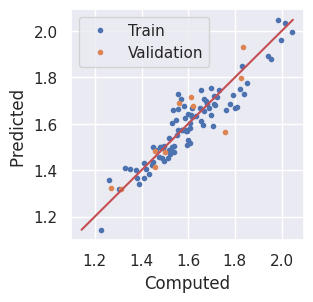

Epoch: 241, Train MAE: 0.0608, Val MAE: 0.0870
Epoch: 242, Train MAE: 0.0572, Val MAE: 0.0871
Epoch: 243, Train MAE: 0.0671, Val MAE: 0.0887
Epoch: 244, Train MAE: 0.0641, Val MAE: 0.0904
Epoch: 245, Train MAE: 0.0657, Val MAE: 0.0889
Epoch: 246, Train MAE: 0.0566, Val MAE: 0.0864
Epoch: 247, Train MAE: 0.0582, Val MAE: 0.0844
Epoch: 248, Train MAE: 0.0632, Val MAE: 0.0840
Epoch: 249, Train MAE: 0.0681, Val MAE: 0.0842
Epoch: 250, Train MAE: 0.0651, Val MAE: 0.0845


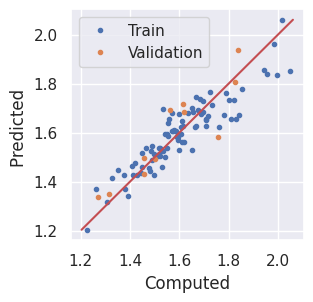

Epoch: 251, Train MAE: 0.0699, Val MAE: 0.0860
Epoch: 252, Train MAE: 0.0597, Val MAE: 0.0888
Epoch: 253, Train MAE: 0.0587, Val MAE: 0.0905
Epoch: 254, Train MAE: 0.0632, Val MAE: 0.0898
Epoch: 255, Train MAE: 0.0604, Val MAE: 0.0875
Epoch: 256, Train MAE: 0.0623, Val MAE: 0.0857
Epoch: 257, Train MAE: 0.0634, Val MAE: 0.0850
Epoch: 258, Train MAE: 0.0675, Val MAE: 0.0843
Epoch: 259, Train MAE: 0.0632, Val MAE: 0.0842
Epoch: 260, Train MAE: 0.0589, Val MAE: 0.0842


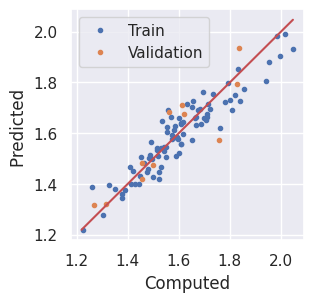

Epoch: 261, Train MAE: 0.0581, Val MAE: 0.0843
Epoch: 262, Train MAE: 0.0561, Val MAE: 0.0847
Epoch: 263, Train MAE: 0.0581, Val MAE: 0.0863
Epoch: 264, Train MAE: 0.0621, Val MAE: 0.0888
Epoch: 265, Train MAE: 0.0587, Val MAE: 0.0896
Epoch: 266, Train MAE: 0.0541, Val MAE: 0.0882
Epoch: 267, Train MAE: 0.0566, Val MAE: 0.0864
Epoch: 268, Train MAE: 0.0568, Val MAE: 0.0845
Epoch: 269, Train MAE: 0.0567, Val MAE: 0.0832
Epoch: 270, Train MAE: 0.0592, Val MAE: 0.0824


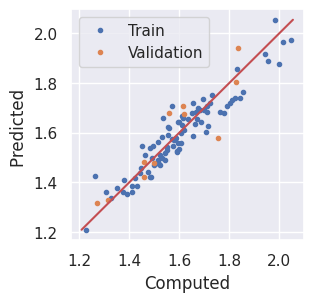

Epoch: 271, Train MAE: 0.0566, Val MAE: 0.0819
Epoch: 272, Train MAE: 0.0485, Val MAE: 0.0827
Epoch: 273, Train MAE: 0.0575, Val MAE: 0.0849
Epoch: 274, Train MAE: 0.0581, Val MAE: 0.0860
Epoch: 275, Train MAE: 0.0554, Val MAE: 0.0849
Epoch: 276, Train MAE: 0.0561, Val MAE: 0.0820
Epoch: 277, Train MAE: 0.0562, Val MAE: 0.0797
Epoch: 278, Train MAE: 0.0628, Val MAE: 0.0786
Epoch: 279, Train MAE: 0.0562, Val MAE: 0.0786
Epoch: 280, Train MAE: 0.0619, Val MAE: 0.0792


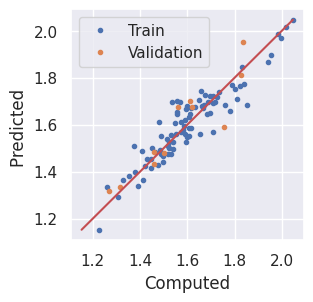

Epoch: 281, Train MAE: 0.0614, Val MAE: 0.0800
Epoch: 282, Train MAE: 0.0598, Val MAE: 0.0830
Epoch: 283, Train MAE: 0.0596, Val MAE: 0.0850
Epoch: 284, Train MAE: 0.0536, Val MAE: 0.0850
Epoch: 285, Train MAE: 0.0566, Val MAE: 0.0825
Epoch: 286, Train MAE: 0.0529, Val MAE: 0.0806
Epoch: 287, Train MAE: 0.0589, Val MAE: 0.0798
Epoch: 288, Train MAE: 0.0558, Val MAE: 0.0799
Epoch: 289, Train MAE: 0.0574, Val MAE: 0.0805
Epoch: 290, Train MAE: 0.0560, Val MAE: 0.0820


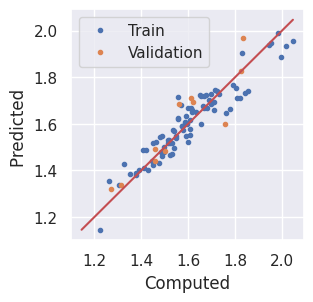

Epoch: 291, Train MAE: 0.0560, Val MAE: 0.0838
Epoch: 292, Train MAE: 0.0553, Val MAE: 0.0845
Epoch: 293, Train MAE: 0.0525, Val MAE: 0.0838
Epoch: 294, Train MAE: 0.0581, Val MAE: 0.0824
Epoch: 295, Train MAE: 0.0523, Val MAE: 0.0806
Epoch: 296, Train MAE: 0.0539, Val MAE: 0.0801
Epoch: 297, Train MAE: 0.0541, Val MAE: 0.0796
Epoch: 298, Train MAE: 0.0653, Val MAE: 0.0795
Epoch: 299, Train MAE: 0.0517, Val MAE: 0.0798
Epoch: 300, Train MAE: 0.0586, Val MAE: 0.0809


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

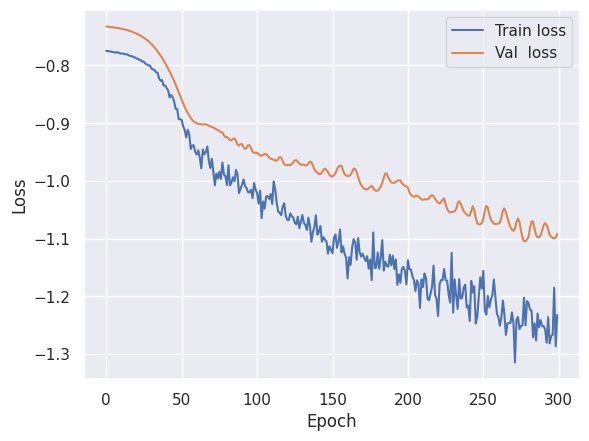

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

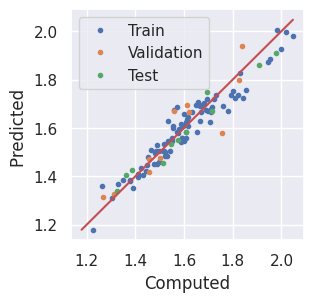

Train MAE: 0.0473, Val MAE: 0.0786, Test MAE: 0.0426


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
